In [409]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

# import ttd_experiment as ttd

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import random
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, roc_auc_score

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


In [425]:
df_raw = dw.td_query('''
select age
       ,gender
       ,waiting_day_1st_txn_bucket
       ,COAlESCE(user_first_txn_refund_category,'no refund') as user_first_txn_refund_category
       ,order_cnt
       ,min_shipping_time_shown_avg
       ,max_shipping_time_shown_avg
       ,mix_ttd_avg
       ,gmv
       ,gmv_avg
       ,user_ltv_segment
       ,previous_m_is_churned
       ,late_days_avg
       ,late_order_p
       ,refund_order_p
       ,lr_order_p
       ,we_order_p
       
       ,m_is_churned
from analytics.jay_churn_model_training_base
where country_code = 'US'
'''
# ,job_id=784968993
,engine='presto'
                )

You can look at job id 784968993


In [426]:
df = df_raw.copy()

In [427]:
df.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,user_ltv_segment,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,m_is_churned
0,NaN,1,16.2,no refund,1,5.0,7.0,5.0,25.0,24.99,ltv_med,0,0.0,0.0,0.0,0.0,100.0,0
1,NaN,1,0.0,no refund,2,17.5,31.0,9.0,3.0,1.50,ltv_low,0,0.0,0.0,0.0,0.0,0.0,1
2,NaN,2,94.0,no refund,2,13.5,31.0,NaN,8.0,4.00,ltv_low,0,0.0,0.0,0.0,0.0,0.0,1
3,NaN,1,0.0,no refund,1,13.0,25.0,14.0,1.0,1.00,ltv_low,0,0.0,0.0,0.0,0.0,0.0,1
4,NaN,2,0.0,no refund,1,17.0,30.0,14.0,26.9,26.90,ltv_med,0,0.0,0.0,0.0,0.0,0.0,0


In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5412887 entries, 0 to 5412886
Data columns (total 18 columns):
age                               float64
gender                            int64
waiting_day_1st_txn_bucket        float64
user_first_txn_refund_category    object
order_cnt                         int64
min_shipping_time_shown_avg       float64
max_shipping_time_shown_avg       float64
mix_ttd_avg                       float64
gmv                               float64
gmv_avg                           float64
user_ltv_segment                  object
previous_m_is_churned             int64
late_days_avg                     float64
late_order_p                      float64
refund_order_p                    float64
lr_order_p                        float64
we_order_p                        float64
m_is_churned                      int64
dtypes: float64(12), int64(4), object(2)
memory usage: 743.3+ MB


## transform the categorical data by one-hot-encoding

In [429]:
# label encoding the feature
le = LabelEncoder()
df['user_first_txn_refund_cat'] = le.fit_transform(df['user_first_txn_refund_category'])
df['user_ltv_segment_cat'] = le.fit_transform(df['user_ltv_segment'])

# creating instance of one-hot-encoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())
# # merge with main df bridge_df on key values
# df = df.join(enc_df)

df_encoding = pd.get_dummies(df[['gender','user_first_txn_refund_category','user_ltv_segment']], prefix_sep='_',columns=['gender','user_first_txn_refund_category','user_ltv_segment'] , 
                             drop_first=False)

df_encoding.head()

,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
0,0,1,0,0,1,0,0,0,1
1,0,1,0,0,1,0,0,1,0
2,0,0,1,0,1,0,0,1,0
3,0,1,0,0,1,0,0,1,0
4,0,0,1,0,1,0,0,0,1


In [430]:
df_encoding.shape, df.shape

((5412887, 9), (5412887, 20))

In [431]:
df2 = pd.concat([df, df_encoding], axis=1)
df2.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,user_ltv_segment_cat,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
0,NaN,1,16.2,no refund,1,5.0,7.0,5.0,25.0,24.99,...,2,0,1,0,0,1,0,0,0,1
1,NaN,1,0.0,no refund,2,17.5,31.0,9.0,3.0,1.50,...,1,0,1,0,0,1,0,0,1,0
2,NaN,2,94.0,no refund,2,13.5,31.0,NaN,8.0,4.00,...,1,0,0,1,0,1,0,0,1,0
3,NaN,1,0.0,no refund,1,13.0,25.0,14.0,1.0,1.00,...,1,0,1,0,0,1,0,0,1,0
4,NaN,2,0.0,no refund,1,17.0,30.0,14.0,26.9,26.90,...,2,0,0,1,0,1,0,0,0,1


In [432]:
df2.shape

(5412887, 29)

## explore and visulize the data

In [267]:
df2.previous_m_is_churned.sum(),df2.m_is_churned.sum()

(0, 4479317)

In [268]:
df2.columns.values

array(['age', 'gender', 'waiting_day_1st_txn_bucket',
       'user_first_txn_refund_category', 'order_cnt',
       'min_shipping_time_shown_avg', 'max_shipping_time_shown_avg',
       'mix_ttd_avg', 'gmv', 'gmv_avg', 'user_ltv_segment',
       'previous_m_is_churned', 'late_days_avg', 'late_order_p',
       'refund_order_p', 'lr_order_p', 'we_order_p', 'm_is_churned',
       'user_first_txn_refund_cat', 'user_ltv_segment_cat',
       'user_first_txn_refund_category_logistics refund',
       'user_first_txn_refund_category_no refund',
       'user_first_txn_refund_category_other refund',
       'user_ltv_segment_ltv_high', 'user_ltv_segment_ltv_low',
       'user_ltv_segment_ltv_med'], dtype=object)

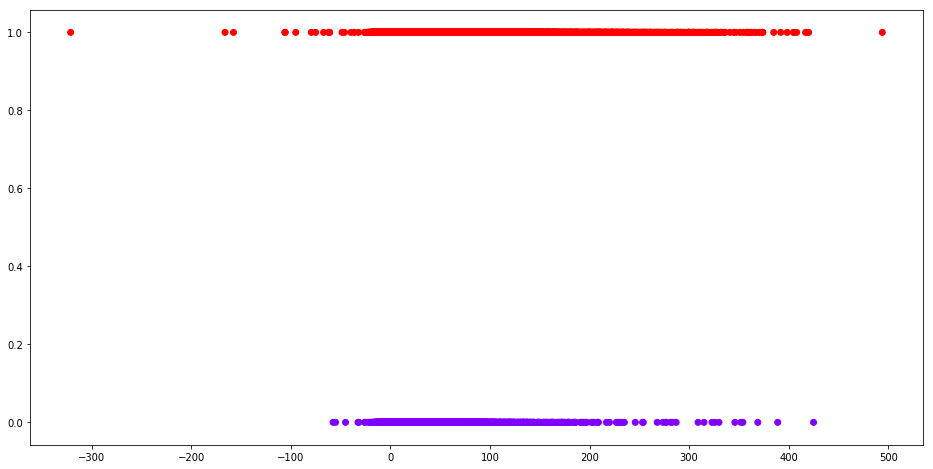

In [57]:
plt.figure(figsize=(16,8))
plt.scatter(x=df2['mix_ttd_avg'], y=df2['m_is_churned'], c=df2['m_is_churned'] , cmap='rainbow')

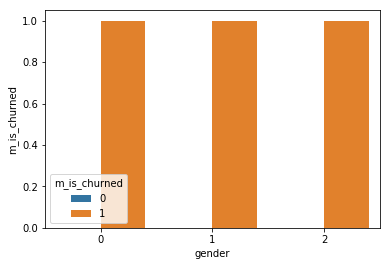

In [112]:
sns.barplot(x='gender',y='m_is_churned', data=df2, hue = 'm_is_churned')

### handle missing values

In [433]:
features = df2.columns.values
a = list()
for f in features:
    a.append(100.0*sum(df2[f].isnull())/df2.shape[0])
df_missing = pd.DataFrame(a,index=features,columns=['missing_value_perc'])
df_missing

,missing_value_perc
age,96.122106
gender,0.000000
waiting_day_1st_txn_bucket,0.000000
user_first_txn_refund_category,0.000000
order_cnt,0.000000
min_shipping_time_shown_avg,0.005672
max_shipping_time_shown_avg,0.005672
mix_ttd_avg,39.084171
gmv,0.000000
gmv_avg,0.000000


#### Obviously, age should be dropped from feature list, min_shipping_time_shown_avg and max_shipping_time_shown_avg can drop the samples with missing value
#### need more investigation on mix_ttd_avg

Text(0.5,1,'avg churn rate is 82.75282672629227%')

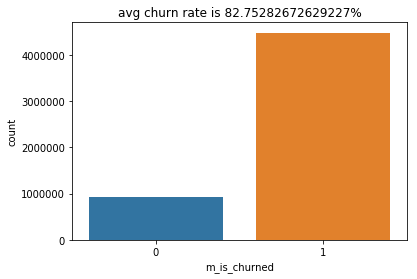

In [180]:
### check overall y distribution 
sns.countplot(x='m_is_churned', data=df2)
plt.title('avg churn rate is {}%'.format(100.0*df2.m_is_churned.sum()/len(df2.m_is_churned)))

Text(0.5,1,'avg churn rate is 90.39744146055317%')

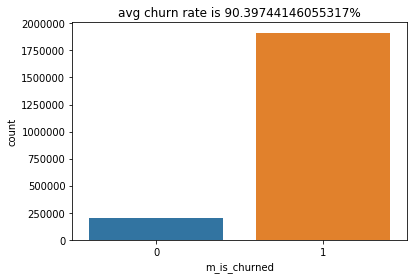

In [179]:
### check mix_ttd_avg is null part, y distribution 
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.isnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.isnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.isnull()].m_is_churned)))

Text(0.5,1,'avg churn rate is 77.84796978138206%')

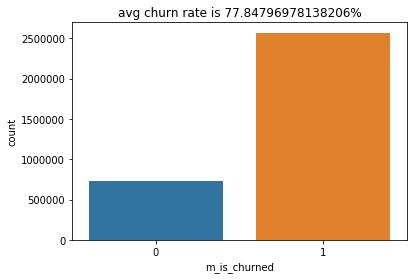

In [178]:
### check mix_ttd_avg is NOT null part, y distribution 
sns.countplot(x='m_is_churned', data=df2[df2.mix_ttd_avg.notnull()])
plt.title('avg churn rate is {}%'.format(100.0*df2[df2.mix_ttd_avg.notnull()].m_is_churned.sum()/len(df2[df2.mix_ttd_avg.notnull()].m_is_churned)))

### method-1: drop all samples with at least 1 missing value

In [336]:
df3 = df2.dropna(subset=['min_shipping_time_shown_avg', 'max_shipping_time_shown_avg','mix_ttd_avg'], inplace=False)
df3.shape

(3297305, 29)

In [337]:
features = df3.columns.values
a = list()
for f in features:
    a.append(100.0*sum(df3[f].isnull())/df3.shape[0])
df_missing = pd.DataFrame(a,index=features,columns=['missing_value_perc'])
df_missing

,missing_value_perc
age,95.372494
gender,0.000000
waiting_day_1st_txn_bucket,0.000000
user_first_txn_refund_category,0.000000
order_cnt,0.000000
min_shipping_time_shown_avg,0.000000
max_shipping_time_shown_avg,0.000000
mix_ttd_avg,0.000000
gmv,0.000000
gmv_avg,0.000000


### method-2: drop age col, drop samples with missing value from min_shipping_time_shown_avg, max_shipping_time_shown_avg
###           And then Impute value on mix_ttd_avg

In [171]:
## check which other feature has the highest corrrelation with ttd_avg, then use the that feature to create bucket and impute the ttd_avg value for each created bucket. 
## it shows 'we_order_p' & 'max_shipping_time_shown_avg' have the highest correlation with 'mix_ttd_avg'

Text(0.5,1,'distribution of users profile - we_order_p')

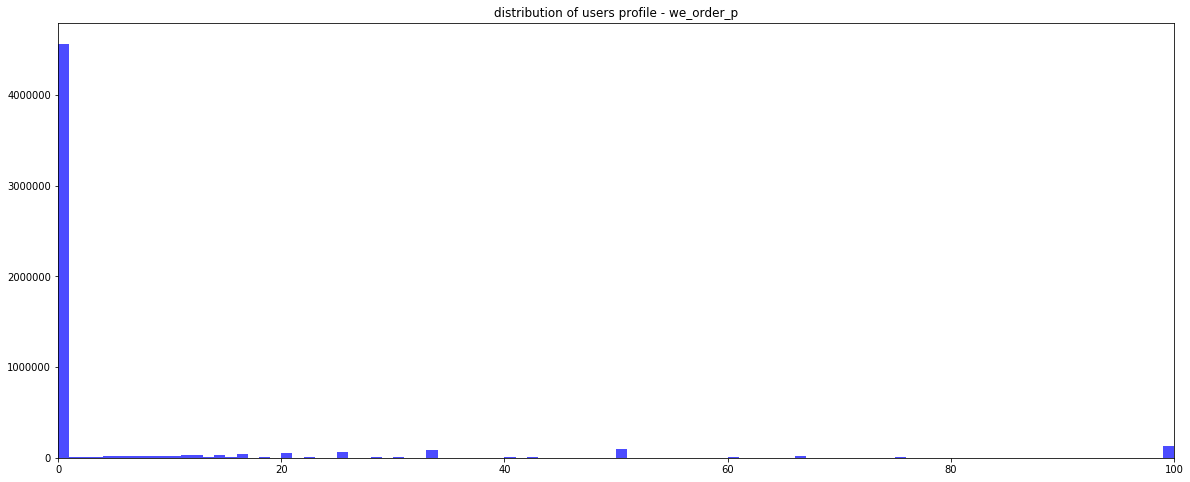

In [434]:
plt.figure(figsize=(20,8))
plt.xlim(0, 100)
plt.hist(x=df2.we_order_p.dropna(axis='index'), bins=100, color='blue', alpha=0.7)
plt.title('distribution of users profile - we_order_p')

Text(0.5,1,'distribution of users profile - we_order_p')

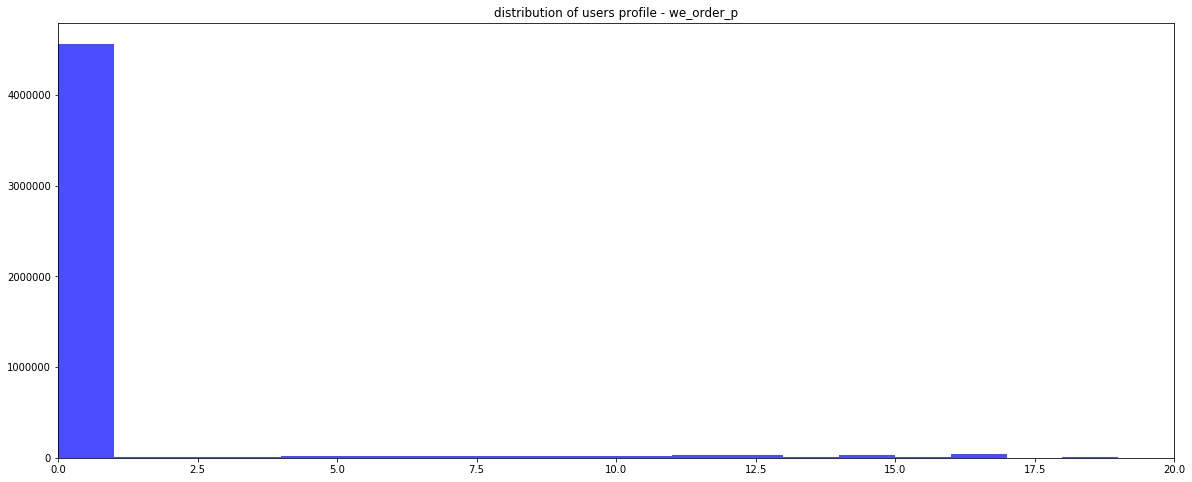

In [304]:
plt.figure(figsize=(20,8))
plt.xlim(0, 20)
plt.hist(x=df2.we_order_p.dropna(axis='index'), bins=100, color='blue', alpha=0.7)
plt.title('distribution of users profile - we_order_p')

Text(0.5,1,'distribution of users profile - max_shipping_time_shown_avg')

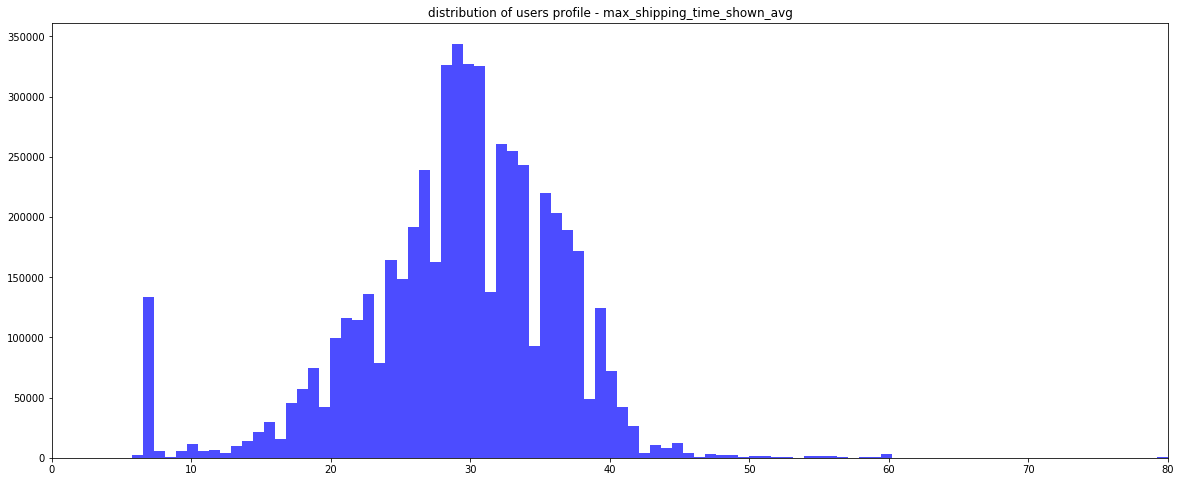

In [302]:
plt.figure(figsize=(20,8))
plt.xlim(0,80)
plt.hist(x=df2.max_shipping_time_shown_avg.dropna(axis='index'), bins=100, color='blue', alpha=0.7)
plt.title('distribution of users profile - max_shipping_time_shown_avg')

In [435]:
def max_shown_bucket(x):
    if x<10:
        bucket = '10-'
    elif x<=20 :
        bucket = '10-20'
    elif x<=25 :
        bucket = '20-25'
    elif x<=30 :
        bucket = '25-30'
    elif x<=35 :
        bucket = '30-35'
    elif x<=40 :
        bucket = '35-40'
    elif x<=50 :
        bucket = '40-50'
    elif x>50 :
        bucket = '50+'
    return bucket

In [436]:
def we_bucket(x):
    if x<=0:
        bucket = '0-'
    elif x<=2 :
        bucket = '0-2'
    elif x<=5 :
        bucket = '2-5'
    elif x<=10 :
        bucket = '5-10'
    elif x<=20 :
        bucket = '10-20'
    elif x<=40 :
        bucket = '20-40'
    elif x<=90 :
        bucket = '40-90'
    elif x>90 :
        bucket = '90+'
    return bucket

In [437]:
df4.columns

Index(['age', 'gender', 'waiting_day_1st_txn_bucket',
       'user_first_txn_refund_category', 'order_cnt',
       'min_shipping_time_shown_avg', 'max_shipping_time_shown_avg',
       'mix_ttd_avg', 'gmv', 'gmv_avg', 'user_ltv_segment',
       'previous_m_is_churned', 'late_days_avg', 'late_order_p',
       'refund_order_p', 'lr_order_p', 'we_order_p', 'm_is_churned',
       'user_first_txn_refund_cat', 'user_ltv_segment_cat', 'gender_0',
       'gender_1', 'gender_2',
       'user_first_txn_refund_category_logistics refund',
       'user_first_txn_refund_category_no refund',
       'user_first_txn_refund_category_other refund',
       'user_ltv_segment_ltv_high', 'user_ltv_segment_ltv_low',
       'user_ltv_segment_ltv_med', 'we_bucket', 'max_shown_bucket'],
      dtype='object')

In [438]:
df4 = df2.dropna(subset=['min_shipping_time_shown_avg', 'max_shipping_time_shown_avg'], inplace=False)
df4['we_bucket'] = df4['we_order_p'].apply(lambda x: we_bucket(x))
df4['max_shown_bucket'] = df4['max_shipping_time_shown_avg'].apply(lambda x: max_shown_bucket(x))
df4.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(5412580, 31)

In [439]:
df_group = df4[['we_bucket','max_shown_bucket','mix_ttd_avg']].groupby(['we_bucket','max_shown_bucket'],as_index=False)['mix_ttd_avg'].mean()
df_group.columns = ['we_bucket','max_shown_bucket','bucket_ttd_avg']
df5 = df4.merge(df_group,how='left',on=['we_bucket','max_shown_bucket'])
df5.head()

,age,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_category,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,...,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med,we_bucket,max_shown_bucket,bucket_ttd_avg
0,NaN,1,16.2,no refund,1,5.0,7.0,5.0,25.0,24.99,...,0,0,1,0,0,0,1,90+,10-,4.597052
1,NaN,1,0.0,no refund,2,17.5,31.0,9.0,3.0,1.50,...,0,0,1,0,0,1,0,0-,30-35,17.569778
2,NaN,2,94.0,no refund,2,13.5,31.0,NaN,8.0,4.00,...,1,0,1,0,0,1,0,0-,30-35,17.569778
3,NaN,1,0.0,no refund,1,13.0,25.0,14.0,1.0,1.00,...,0,0,1,0,0,1,0,0-,20-25,15.582878
4,NaN,2,0.0,no refund,1,17.0,30.0,14.0,26.9,26.90,...,1,0,1,0,0,0,1,0-,25-30,16.998470


In [440]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5412580 entries, 0 to 5412579
Data columns (total 32 columns):
age                                                float64
gender                                             int64
waiting_day_1st_txn_bucket                         float64
user_first_txn_refund_category                     object
order_cnt                                          int64
min_shipping_time_shown_avg                        float64
max_shipping_time_shown_avg                        float64
mix_ttd_avg                                        float64
gmv                                                float64
gmv_avg                                            float64
user_ltv_segment                                   object
previous_m_is_churned                              int64
late_days_avg                                      float64
late_order_p                                       float64
refund_order_p                                     float64
lr_order_p

In [441]:
mask = df5.mix_ttd_avg.isnull()
df5.loc[mask,'mix_ttd_avg']=df5.loc[mask,'bucket_ttd_avg']

In [442]:
a = df5
features = a.columns.values
b = list()
for f in features:
    b.append(100.0*sum(a[f].isnull())/a.shape[0])
df_missing = pd.DataFrame(b,index=features,columns=['missing_value_perc'])
df_missing

,missing_value_perc
age,96.122164
gender,0.000000
waiting_day_1st_txn_bucket,0.000000
user_first_txn_refund_category,0.000000
order_cnt,0.000000
min_shipping_time_shown_avg,0.000000
max_shipping_time_shown_avg,0.000000
mix_ttd_avg,0.000000
gmv,0.000000
gmv_avg,0.000000


### method-3: explore other classification models, which can handle the missing value, such as XGBoost tree

### check the indepedent of potential features

In [443]:
df_corr = df2[['gender','waiting_day_1st_txn_bucket','user_first_txn_refund_cat','order_cnt','min_shipping_time_shown_avg','max_shipping_time_shown_avg',
               'mix_ttd_avg','gmv','gmv_avg','previous_m_is_churned','late_days_avg','late_order_p','refund_order_p','lr_order_p','we_order_p','user_ltv_segment_cat']]
df_corr.corr()

,gender,waiting_day_1st_txn_bucket,user_first_txn_refund_cat,order_cnt,min_shipping_time_shown_avg,max_shipping_time_shown_avg,mix_ttd_avg,gmv,gmv_avg,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,user_ltv_segment_cat
gender,1.000000,0.035388,-0.014293,0.056775,0.061752,0.059804,0.073520,-0.010739,-0.097304,NaN,0.004163,-0.010077,-0.028835,-0.006760,-0.066206,0.015204
waiting_day_1st_txn_bucket,0.035388,1.000000,-0.000333,0.011904,-0.062741,-0.059000,0.006148,0.015263,0.033960,NaN,0.015478,0.020633,-0.000743,0.004940,0.033784,0.009325
user_first_txn_refund_cat,-0.014293,-0.000333,1.000000,0.016003,-0.040528,-0.054953,-0.038300,0.062271,0.102586,NaN,-0.006307,0.004591,0.545851,-0.154539,0.051121,-0.051390
order_cnt,0.056775,0.011904,0.016003,1.000000,0.029270,0.025908,0.067976,0.357203,-0.028106,NaN,0.085557,-0.002402,0.016376,-0.008371,-0.017213,-0.222102
min_shipping_time_shown_avg,0.061752,-0.062741,-0.040528,0.029270,1.000000,0.789395,0.318092,-0.051982,-0.210965,NaN,-0.101862,-0.152987,-0.038180,-0.044102,-0.457677,0.023221
max_shipping_time_shown_avg,0.059804,-0.059000,-0.054953,0.025908,0.789395,1.000000,0.360364,-0.069647,-0.256595,NaN,-0.150982,-0.218598,-0.071062,-0.066626,-0.567695,0.034537
mix_ttd_avg,0.073520,0.006148,-0.038300,0.067976,0.318092,0.360364,1.000000,0.002203,-0.145673,NaN,0.083592,0.069853,-0.024950,0.016451,-0.383753,-0.015248
gmv,-0.010739,0.015263,0.062271,0.357203,-0.051982,-0.069647,0.002203,1.000000,0.297669,NaN,0.110595,0.021253,0.084752,-0.004734,0.073738,-0.304383
gmv_avg,-0.097304,0.033960,0.102586,-0.028106,-0.210965,-0.256595,-0.145673,0.297669,1.000000,NaN,0.034063,0.069784,0.154625,0.011516,0.226701,-0.176466
previous_m_is_churned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### refund_order_p & user_first_txn_refund_cat 54% ; 
#### min_shipping_time_shown_avg & max_shipping_time_shown_avg 79%; 
#### max_shipping_time_shown_avg & we_order_p -57%;
#### late_days_avg & late_order_p 56%
### can drop min_shipping_time_shown_avg & gmv from feature list and keep max_shipping_time_shown_avg

## split and standardize/scale the training and test data

In [374]:
df5.columns

Index(['age', 'gender', 'waiting_day_1st_txn_bucket',
       'user_first_txn_refund_category', 'order_cnt',
       'min_shipping_time_shown_avg', 'max_shipping_time_shown_avg',
       'mix_ttd_avg', 'gmv', 'gmv_avg', 'user_ltv_segment',
       'previous_m_is_churned', 'late_days_avg', 'late_order_p',
       'refund_order_p', 'lr_order_p', 'we_order_p', 'm_is_churned',
       'user_first_txn_refund_cat', 'user_ltv_segment_cat', 'gender_0',
       'gender_1', 'gender_2',
       'user_first_txn_refund_category_logistics refund',
       'user_first_txn_refund_category_no refund',
       'user_first_txn_refund_category_other refund',
       'user_ltv_segment_ltv_high', 'user_ltv_segment_ltv_low',
       'user_ltv_segment_ltv_med', 'we_bucket', 'max_shown_bucket',
       'bucket_ttd_avg'],
      dtype='object')

In [444]:
X= df5.drop(['m_is_churned','gender','age','min_shipping_time_shown_avg','user_first_txn_refund_category','user_ltv_segment','user_first_txn_refund_cat','user_ltv_segment_cat','gmv',
             'we_bucket','max_shown_bucket','bucket_ttd_avg'],axis=1)

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

y= df5.m_is_churned

In [445]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,random_state=66,test_size=0.3, stratify=y)

In [446]:
x_train.shape,x_test.shape

((3788806, 20), (1623774, 20))

In [447]:
x_train.head()

,waiting_day_1st_txn_bucket,order_cnt,max_shipping_time_shown_avg,mix_ttd_avg,gmv_avg,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
4942500,-0.479838,-0.243730,0.941967,0.451030,-0.390371,0.0,-0.183849,-0.169027,-0.207645,-0.048191,-0.313516,-0.147208,-0.832339,0.869386,-0.177937,0.284895,-0.215506,-0.717296,1.422768,-0.701206
72153,-0.489137,-0.319963,-0.161343,0.126318,-0.492409,0.0,-0.183849,-0.169027,-0.207645,-0.048191,-0.313516,-0.147208,-0.832339,0.869386,-0.177937,0.284895,-0.215506,-0.717296,1.422768,-0.701206
3887476,-0.440313,-0.015032,0.666140,-0.166563,-0.104663,0.0,-0.183849,-0.169027,-0.207645,-0.048191,-0.313516,-0.147208,1.201433,-1.150237,-0.177937,0.284895,-0.215506,1.394124,-0.702855,-0.701206
3391166,-0.489137,-0.091265,-1.085364,0.126543,0.237165,0.0,-0.183849,-0.169027,-0.207645,-0.048191,-0.313516,-0.147208,-0.832339,0.869386,-0.177937,0.284895,-0.215506,1.394124,-0.702855,-0.701206
4711673,-0.489137,-0.319963,-1.126739,-0.081140,-0.492409,0.0,-0.183849,-0.169027,-0.207645,-0.048191,-0.313516,-0.147208,1.201433,-1.150237,-0.177937,0.284895,-0.215506,-0.717296,1.422768,-0.701206


In [448]:
x_train.describe()

,waiting_day_1st_txn_bucket,order_cnt,max_shipping_time_shown_avg,mix_ttd_avg,gmv_avg,previous_m_is_churned,late_days_avg,late_order_p,refund_order_p,lr_order_p,we_order_p,gender_0,gender_1,gender_2,user_first_txn_refund_category_logistics refund,user_first_txn_refund_category_no refund,user_first_txn_refund_category_other refund,user_ltv_segment_ltv_high,user_ltv_segment_ltv_low,user_ltv_segment_ltv_med
count,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3788806.0,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06,3.788806e+06
mean,4.366936e-05,-1.076164e-04,-3.177419e-04,-5.535802e-05,6.628096e-05,0.0,3.645140e-04,2.834821e-04,3.004839e-05,-6.351525e-05,3.538157e-04,-4.759001e-04,-4.579846e-04,5.932847e-04,-7.550350e-04,5.222474e-04,-3.588484e-05,6.798798e-06,6.423762e-05,-7.113890e-05
std,1.000040e+00,6.660975e-01,9.999961e-01,1.001278e+00,1.011459e+00,0.0,1.001240e+00,1.001097e+00,1.000087e+00,9.993798e-01,1.000548e+00,9.984174e-01,9.999155e-01,9.999166e-01,9.979433e-01,9.991575e-01,9.999207e-01,1.000002e+00,1.000023e+00,9.999743e-01
min,-4.891374e-01,-3.199626e-01,-3.885013e+00,-4.940823e+01,-5.434284e-01,0.0,-1.838485e-01,-1.690267e-01,-2.076452e-01,-4.819097e-02,-3.135159e-01,-1.472081e-01,-8.323393e-01,-1.150237e+00,-1.779373e-01,-3.510069e+00,-2.155064e-01,-7.172965e-01,-7.028552e-01,-7.012060e-01
25%,-4.891374e-01,-3.199626e-01,-5.061269e-01,-4.010467e-01,-3.970034e-01,0.0,-1.838485e-01,-1.690267e-01,-2.076452e-01,-4.819097e-02,-3.135159e-01,-1.472081e-01,-8.323393e-01,-1.150237e+00,-1.779373e-01,2.848947e-01,-2.155064e-01,-7.172965e-01,-7.028552e-01,-7.012060e-01
50%,-4.879749e-01,-1.674974e-01,8.690201e-02,1.263184e-01,-2.260891e-01,0.0,-1.838485e-01,-1.690267e-01,-2.076452e-01,-4.819097e-02,-3.135159e-01,-1.472081e-01,-8.323393e-01,8.693859e-01,-1.779373e-01,2.848947e-01,-2.155064e-01,-7.172965e-01,-7.028552e-01,-7.012060e-01
75%,-1.066785e-01,6.120043e-02,6.661396e-01,3.756820e-01,1.157394e-01,0.0,-1.838485e-01,-1.690267e-01,-2.076452e-01,-4.819097e-02,-3.135159e-01,-1.472081e-01,1.201433e+00,8.693859e-01,-1.779373e-01,2.848947e-01,-2.155064e-01,1.394124e+00,1.422768e+00,1.426115e+00
max,5.171022e+00,1.383472e+02,7.010170e+00,5.991999e+01,5.014853e+02,0.0,2.266801e+01,1.037254e+01,6.037489e+00,2.927968e+01,5.278322e+00,6.793104e+00,1.201433e+00,8.693859e-01,5.619957e+00,2.848947e-01,4.640233e+00,1.394124e+00,1.422768e+00,1.426115e+00


## build and fit the logistics regression model

In [449]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
round(100*log_reg.score(x_test,y_test),1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


82.96

In [450]:
log_reg_l1 = LogisticRegression(C=0.001, penalty='l1')
log_reg_l1.fit(x_train, y_train)
round(100*log_reg_l1.score(x_test,y_test),1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


82.96

## predict the testing data

In [451]:
y_pred = log_reg.predict(x_test)
y_pred_prob = log_reg.predict_proba(x_test)
y_pred,y_pred_prob

(array([1, 1, 1, ..., 1, 0, 1]), array([[0.16079715, 0.83920285],
        [0.16013696, 0.83986304],
        [0.45896348, 0.54103652],
        ...,
        [0.08711152, 0.91288848],
        [0.64972237, 0.35027763],
        [0.12042116, 0.87957884]]))

In [467]:
y_pred_l1 = log_reg_l1.predict(x_test)
y_pred_prob_l1 = log_reg_l1.predict_proba(x_test)
y_pred_l1, y_pred_prob_l1

(array([1, 1, 1, ..., 1, 0, 1]), array([[0.15992846, 0.84007154],
        [0.16049596, 0.83950404],
        [0.45831043, 0.54168957],
        ...,
        [0.08847566, 0.91152434],
        [0.64755317, 0.35244683],
        [0.12151635, 0.87848365]]))

## evalulation metrics

In [453]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.06      0.11    280057
           1       0.83      0.99      0.91   1343717

    accuracy                           0.83   1623774
   macro avg       0.70      0.53      0.51   1623774
weighted avg       0.79      0.83      0.77   1623774



In [454]:
print(classification_report(y_test,y_pred_l1))

              precision    recall  f1-score   support

           0       0.56      0.06      0.11    280057
           1       0.83      0.99      0.91   1343717

    accuracy                           0.83   1623774
   macro avg       0.70      0.52      0.51   1623774
weighted avg       0.79      0.83      0.77   1623774



In [455]:
confusion_matrix(y_test,y_pred)

array([[  17046,  263011],
       [  13632, 1330085]])

In [456]:
confusion_matrix(y_test,y_pred_l1)

array([[  16776,  263281],
       [  13340, 1330377]])

In [457]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_l1).ravel()
tn, fp, fn, tp
# fn=12079 is most important for us
# fn means there are 12079 users actually churned, but the model predicts as not churned.

(16776, 263281, 13340, 1330377)

In [458]:
# recall=0.99 
# 所有真的y=1(churn)中，预测churn对了99.0%

recall=tp/(tp+fn)
round(100*recall,1)

99.0

In [459]:
# precision=0.835
#所有预测为y=1(churn)中，有83.5%真的churn了

precision = tp/(tp+fp)
round(100*precision,1)

83.5

In [460]:
# overall accuracy, equal to above score() = 83.0%
accuracy= (tp+tn)/(tp+tn+fn+fp)
round(100*accuracy,1)

83.0

### grid search on C (the regularization aggresiveness parameter)

In [160]:
grid = GridSearchCV(log_reg_l1,{'C':[0.001,0.01,0.1,1,10]})

In [161]:
grid.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futu

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [162]:
grid.best_params_, grid.best_score_

({'C': 0.001}, 0.7820687288707269)

## coefficient analysis/feature importance

In [462]:
importance = log_reg_l1.coef_[0]
name = x_train.columns
feature_importance = pd.DataFrame(importance,index=name,columns=['importance'])
feature_importance.sort_values(by='importance')

,importance
order_cnt,-0.547783
user_ltv_segment_ltv_high,-0.259097
user_first_txn_refund_category_logistics refund,-0.079945
gender_1,-0.076027
mix_ttd_avg,-0.074586
we_order_p,-0.037903
lr_order_p,-0.029002
waiting_day_1st_txn_bucket,-0.016824
late_days_avg,0.000000
previous_m_is_churned,0.000000


<BarContainer object of 20 artists>

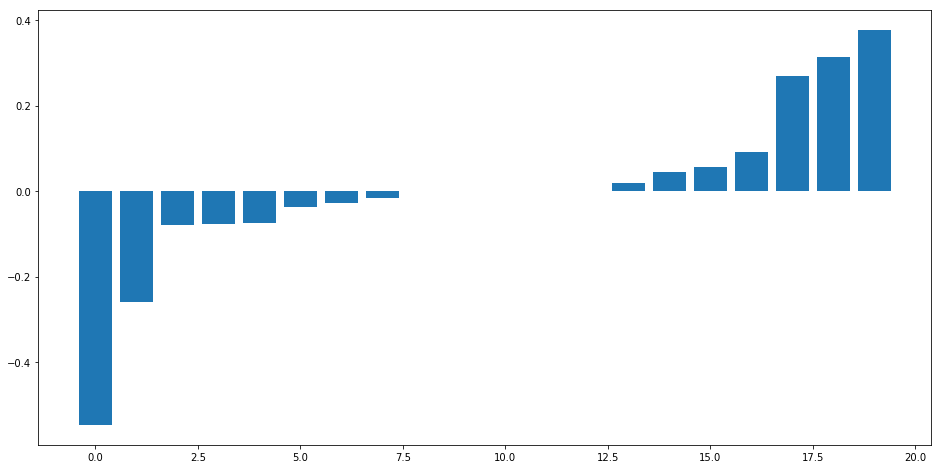

In [463]:
plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance))], feature_importance.sort_values(by='importance').importance)

## to-do list

### 0. imputation on missing value of ttd_avg (Done)
### 1. ROC curve and AUC value (Done)
### 2.simulated TTD impact on churn proba/score
### 8. is the current data(in terms of y value) too unbalanced? need to sample or simulate data to balance? SMOTE sampling
### 3. eliminate features with med correlation （WIP）
### 4. permutation method on feature importance
### 5. Try churn in the future 2-3 months, instead of current 1 month (Done)
### 6. Try start from month-0&1(day0-day60), instead of current month-0(day0-day30), so that we can have more matured logistics related features (Done)
### 7. Use-case: how and where we can leverage this model (WIP)
### 9. explore other classification methods such as random forest, XGBoost and so on.

## ROC curve and AUC value

In [464]:
y_score_log_l1 = log_reg_l1.decision_function(x_test)
base_probs = [0 for _ in range(len(y_test))]
# len(base_probs), len(y_score_log_l1)

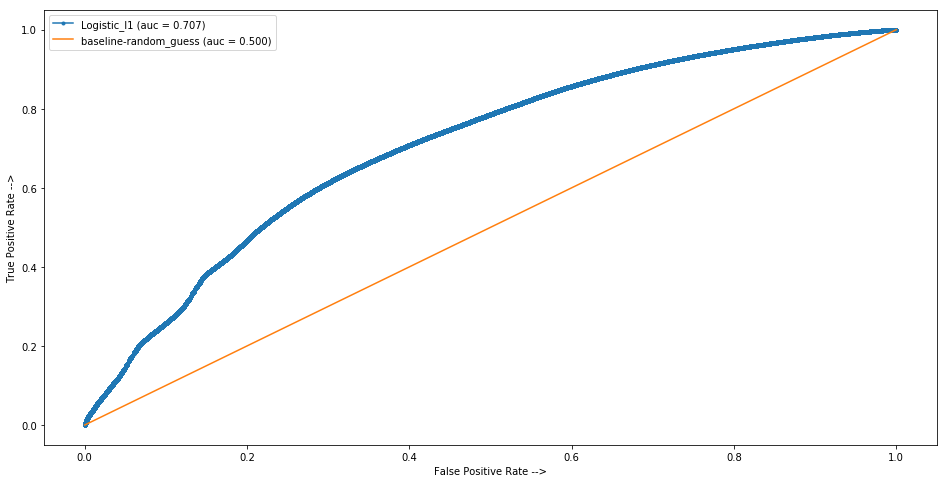

In [475]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_prob_l1[:,1])
auc_logistic = auc(logistic_fpr, logistic_tpr)

base_fpr, base_tpr, base_threshold = roc_curve(y_test, base_probs)
auc_base = auc(base_fpr, base_tpr)

plt.figure(figsize=(16, 8))
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()

plt.show()

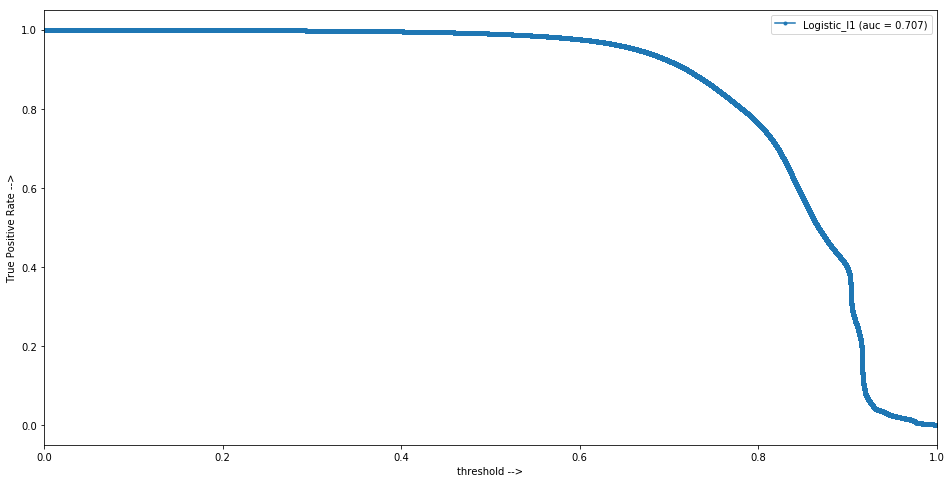

In [474]:
plt.figure(figsize=(16, 8))
plt.plot(threshold, logistic_tpr, marker='.', label='Logistic_l1 (auc = %0.3f)' % auc_logistic)
# plt.plot(base_fpr, base_tpr, linestyle='-', label='baseline-random_guess (auc = %0.3f)' % auc_base)

plt.xlabel('threshold -->')
plt.ylabel('True Positive Rate -->')
plt.xlim(0,1)
plt.legend()

plt.show()